<h1 align="center">Visualization of Segmentation and Registration Results</h1>

在这个笔记本中，我们举例说明了可以显示分割和配准算法结果的各种方法，以便将它们轻松地整合到手稿中。对于交互式数据探索，我们建议使用专用程序(e.g. 3D slicer). 

使用生物医学图像时要记住的两个关键点：

1. 大多数情况下，图像强度具有高动态范围。因此，**为了将它们以适合用于原稿的格式写入文件，我们需要将强度映射到低动态范围（例如[0,255]）** 在SimpleITK中，可以使用[IntensityWindowingImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1IntensityWindowingImageFilter.html)轻松完成.
2. 图像可以在像素之间具有各向异性的间距的间隔。**适用于手稿（例如png，jpg）的文件格式假定各向同性像素间距。这要求我们在写入磁盘之前重新采样图像。**代码单元格中的函数`make_isotropic`解决了这个问题。
以下过滤器及其过程对应物对于各种图像创建任务非常有用，如本笔记本所示：

 * [CastImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1CastImageFilter.html)
 * [ResampleImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ResampleImageFilter.html), one of the more important filters in your toolbox, see [this notebook](21_Transforms_and_Resampling.ipynb) for additional usage details.
 * [TileImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1TileImageFilter.html)
 * [CheckerBoardImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1CheckerBoardImageFilter.html)
 * [ComposeImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ComposeImageFilter.html)
 * [LabelToRGBImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1LabelToRGBImageFilter.html)
 * [ScalarToRGBColormapImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ScalarToRGBColormapImageFilter.html)
 * [LabelOverlayImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1LabelOverlayImageFilter.html)
 * [LabelContourImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1LabelContourImageFilter.html)
 * [LabelMapContourOverlayImageFilter](https://itk.org/SimpleITKDoxygen/html/namespaceitk_1_1simple.html#a4f6af69f85171e44bcff90d7860d456e)

In [ ]:
%matplotlib notebook

import numpy as np

import SimpleITK as sitk
# Utility method that either downloads data from the Girder repository or
# if already downloaded returns the file name for reading from disk (cached data).
%run update_path_to_download_script
from downloaddata import fetch_data as fdata


import gui

# Always write output to a separate directory, we don't want to pollute the source directory. 
import os
OUTPUT_DIR = 'Output'

### resample前后size,space关系

- 原origin_space(各向异性):\[space0,space1,space2\]    原origin_size:\[size0,size1,size2\]

- 新new_space(各向同性):space_new=min(origin_space)

- 由:origin_size\*origin_space=new_space\*new_size

- 所以:new_size=int(round((origin_size\*origin_space)/new_space))

### sitk.Resample(Image image1, VectorUInt32 size, Transform transform, itk::simple::InterpolatorEnum interpolator, VectorDouble outputOrigin, VectorDouble outputSpacing, VectorDouble outputDirection, double defaultPixelValue=0.0, itk::simple::PixelIDValueEnum outputPixelType)

参数:
- image1:输入图像
- size:resample之后的size
- transform：sitk.Transform()
- interpolator：sitk.sitkLinear /sitk.sitkNearestNeighbor
- outputOrigin:输出图像的origin
- outputSpacing:输出图像的spacing
- outputDirection:输出图像的Direction
- defaultPixelValue:0
- outputPixelType:输出图像的像素值类型

返回值:
resample之后的图像

In [4]:
help(sitk.Resample)

Help on function Resample in module SimpleITK.SimpleITK:

Resample(*args)
    Resample(Image image1, Transform transform, itk::simple::InterpolatorEnum interpolator, double defaultPixelValue=0.0, itk::simple::PixelIDValueEnum outputPixelType) -> Image
    Resample(Image image1, Image referenceImage, Transform transform, itk::simple::InterpolatorEnum interpolator, double defaultPixelValue=0.0, itk::simple::PixelIDValueEnum outputPixelType) -> Image
    Resample(Image image1, VectorUInt32 size, Transform transform, itk::simple::InterpolatorEnum interpolator, VectorDouble outputOrigin, VectorDouble outputSpacing, VectorDouble outputDirection, double defaultPixelValue=0.0, itk::simple::PixelIDValueEnum outputPixelType) -> Image



In [2]:
def make_isotropic(image, interpolator = sitk.sitkLinear):
    '''
   将图像重采样到各向同性像素(使用原始像素的最小间距)并保存到文件中。许多文件格式(jpg, png，…)期望像素是各向同性的。
   默认情况下，函数使用线性插值器sitk.sitkLinear。对于标签图像，应该使用sitk.sitkNearestNeighbor插值器，以免引入不存在的标签。
    '''
    original_spacing = image.GetSpacing()
    
    # 如果图像已经是各向同性，返回一份副本
    if all(spc == original_spacing[0] for spc in original_spacing):
        return sitk.Image(image)
    
    # 通过重采样实现各向同性
    original_size = image.GetSize()
    min_spacing = min(original_spacing)
    new_spacing = [min_spacing]*image.GetDimension()
    new_size = [int(round(osz*ospc/min_spacing)) for osz,ospc in zip(original_size, original_spacing)]
    
    return sitk.Resample(image, new_size, sitk.Transform(), interpolator,
                         image.GetOrigin(), new_spacing, image.GetDirection(), 0,
                         image.GetPixelID())

# 组合两个图像-Combining two images

我们可以通过多种方式将两个（部分）重叠的图像叠加在一起。 常见的方法包括：

1.使用alpha混合。

2.使用棋盘图案，其中每个图像中的相邻正方形/框中的像素值。

3.当像素值是标量（灰度图像）时，将两个图像组合在不同的通道中，从而产生彩色图像。

我们将首先加载两个图像，其内容幸运地重叠在物理空间中。 在我们将两者结合起来之前，我们需要对其中一个进行重新采样，以便它们都占据相同的空间区域。 此外，我们还应该重新调整强度，使它们占据相同的范围。 在我们的例子中，我们将根据所需的窗口将它们映射到[0,255]。


### sitk.OtsuThreshold()

获取图像的mask

In [10]:
help(sitk.OtsuThreshold)

Help on function OtsuThreshold in module SimpleITK.SimpleITK:

OtsuThreshold(*args)
    OtsuThreshold(Image image, Image maskImage, uint8_t insideValue=1, uint8_t outsideValue=0, uint32_t numberOfHistogramBins=128, bool maskOutput=True, uint8_t maskValue=255) -> Image
    OtsuThreshold(Image image, uint8_t insideValue=1, uint8_t outsideValue=0, uint32_t numberOfHistogramBins=128, bool maskOutput=True, uint8_t maskValue=255) -> Image



Fetching training_001_mr_T1.mha
Fetching training_001_ct.mha
img1 size: (256, 256, 26)
img1 spacing: (1.25, 1.25, 4.0)
img2_original size: (512, 512, 29)
img2_original spacing: (0.653595, 0.653595, 4.0)
img2_original size: (256, 256, 26)
Max, Min differences of img1 are : 1626.0, 2.0
Max, Min differences of img2 are : 1945.0, -1024.0
Max, Min differences of msk1 are : 1.0, 0.0
Max, Min differences of msk2 are : 1.0, 0.0


<IPython.core.display.Javascript object>


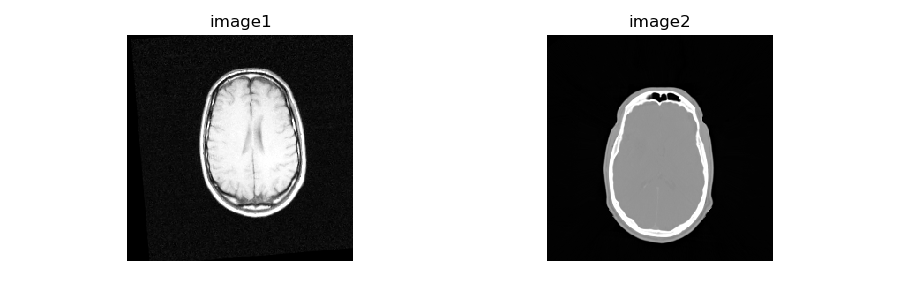

<IPython.core.display.Javascript object>


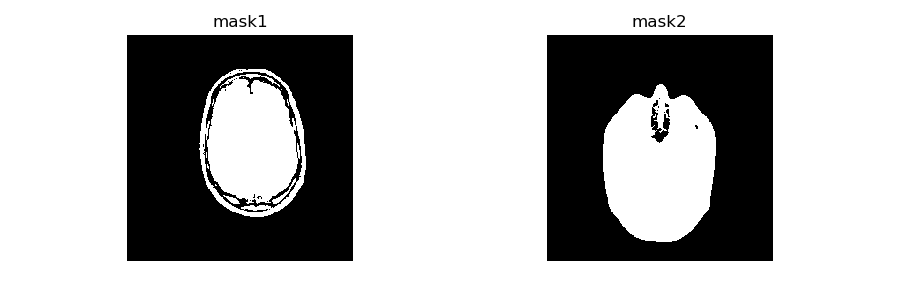

In [29]:
img1 = sitk.ReadImage(fdata("training_001_mr_T1.mha"))
img2_original = sitk.ReadImage(fdata("training_001_ct.mha"))
print("img1 size:",img1.GetSize())
print("img1 spacing:",img1.GetSpacing())
print("img2_original size:",img2_original.GetSize())
print("img2_original spacing:",img2_original.GetSpacing())

#将img2_original重采样到img1相同size
img2 = sitk.Resample(img2_original, img1)
print("img2_original size:",img2.GetSize())

statistics_image_filter=sitk.StatisticsImageFilter()
statistics_image_filter.Execute(img1)
print('Max, Min differences of img1 are : {0}, {1}'.format(statistics_image_filter.GetMaximum(), statistics_image_filter.GetMinimum()))

statistics_image_filter=sitk.StatisticsImageFilter()
statistics_image_filter.Execute(img2)
print('Max, Min differences of img2 are : {0}, {1}'.format(statistics_image_filter.GetMaximum(), statistics_image_filter.GetMinimum()))

# 使用Otsu阈值获取两个图像的前景mask，我们稍后使用它们。
msk1 = sitk.OtsuThreshold(img1,0,1)
msk2 = sitk.OtsuThreshold(img2,0,1)

statistics_image_filter=sitk.StatisticsImageFilter()
statistics_image_filter.Execute(msk1)
print('Max, Min differences of msk1 are : {0}, {1}'.format(statistics_image_filter.GetMaximum(), statistics_image_filter.GetMinimum()))

statistics_image_filter=sitk.StatisticsImageFilter()
statistics_image_filter.Execute(msk2)
print('Max, Min differences of msk2 are : {0}, {1}'.format(statistics_image_filter.GetMaximum(), statistics_image_filter.GetMinimum()))


gui.MultiImageDisplay(image_list = [img1, img2],                   
                      title_list = ['image1', 'image2'],
                      figure_size=(9,3));

gui.MultiImageDisplay(image_list = [msk1, msk2],                   
                      title_list = ['mask1', 'mask2'],
                      figure_size=(9,3));

### 映射图像强度

#### IntensityWindowing(Image image1, double windowMinimum=0.0, double windowMaximum=255, double outputMinimum=0, double outputMaximum=255)

对用户定义的间隔[windowMinimum, windowMaximum]内的输入图像的强度级别应用线性变换。 低于此间隔的值将映射到常量outputMinimum。 低于此间隔的值映射到另一个常量outputMaximum。

In [20]:
# Having identified the desired intensity range for each of the 
# images using the GUI above, we use these values to perform intensity windowing and map the intensity values
# to [0,255] and cast to 8-bit unsigned int

#windowMinimum和 windowMaximum是原图像强度值2%分位数和98%分位数=2,657
img1_255 = sitk.Cast(sitk.IntensityWindowing(img1, windowMinimum=2, windowMaximum=657, 
                                             outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)
img2_255 = sitk.Cast(sitk.IntensityWindowing(img2, windowMinimum=-1018, windowMaximum=1126, 
                                             outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)


statistics_image_filter=sitk.StatisticsImageFilter()
statistics_image_filter.Execute(img1_255)
print('Max, Min differences of msk1 are : {0}, {1}'.format(statistics_image_filter.GetMaximum(), statistics_image_filter.GetMinimum()))

statistics_image_filter=sitk.StatisticsImageFilter()
statistics_image_filter.Execute(img2_255)
print('Max, Min differences of msk2 are : {0}, {1}'.format(statistics_image_filter.GetMaximum(), statistics_image_filter.GetMinimum()))

Max, Min differences of msk1 are : 255.0, 0.0
Max, Min differences of msk2 are : 255.0, 0.0


## 混合图像-Alpha blending

Alpha blending combines the pixels from the two images as follows:
$$
I_{output} = \alpha I_1 + (1-\alpha)I_2,\;\;\; \alpha \in[0.0,1.0]
$$

当我们的图像由前景和背景组成时，我们可以以考虑到这一点的方式使用alpha混合。 我们不是使用上面的公式混合所有像素，而是**仅在前景重叠的区域中使用此公式。 在一个图像的前景与另一个图像的背景重叠的区域中，我们只需复制前景。** 这样可以提高可见性，因为我们没有将包含信息的区域与空区域混合。

The code below allows us to experiment with various alpha blending strategies.

<IPython.core.display.Javascript object>


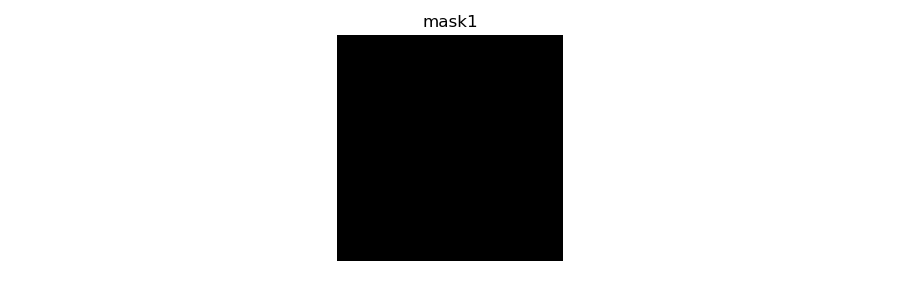

In [25]:
mask1 = sitk.Image(img1.GetSize(), sitk.sitkFloat32)+1.0
mask1.CopyInformation(img1)

gui.MultiImageDisplay(image_list = [mask1],                   
                      title_list = ['mask1'],
                      figure_size=(9,3));

In [27]:
def mask_image_multiply(mask, image):
    components_per_pixel = image.GetNumberOfComponentsPerPixel()
    if  components_per_pixel == 1:
        return mask*image
    else:
        return sitk.Compose([mask*sitk.VectorIndexSelectionCast(image,channel) for channel in range(components_per_pixel)])

def alpha_blend(image1, image2, alpha = 0.5, mask1=None,  mask2=None):
    '''
    Alaph混合两幅图像，像素可以是标量或向量。alpha混合的区域由给定的mask控制。
    '''
    
    if not mask1:
        mask1 = sitk.Image(image1.GetSize(), sitk.sitkFloat32) + 1.0
        mask1.CopyInformation(image1)
    else:
        mask1 = sitk.Cast(mask1, sitk.sitkFloat32)
    
    if not mask2:
        mask2 = sitk.Image(image2.GetSize(),sitk.sitkFloat32) + 1
        mask2.CopyInformation(image2)
    else:        
        mask2 = sitk.Cast(mask2, sitk.sitkFloat32)
    
    
    components_per_pixel = image1.GetNumberOfComponentsPerPixel()
    #通道数>1
    if components_per_pixel>1:
        img1 = sitk.Cast(image1, sitk.sitkVectorFloat32)
        img2 = sitk.Cast(image2, sitk.sitkVectorFloat32)
    else:
        img1 = sitk.Cast(image1, sitk.sitkFloat32)
        img2 = sitk.Cast(image2, sitk.sitkFloat32)
    
    #mask1与mask2的交集处值为1
    intersection_mask = mask1*mask2
    
    intersection_image = mask_image_multiply(alpha*intersection_mask, img1) + \
                         mask_image_multiply((1-alpha)*intersection_mask, img2)
    
    #intersection_image:是相交的前景，
    #mask_image_multiply(mask2-intersection_mask, img2)：img2除相交前景之外的前景
    #mask_image_multiply(mask1-intersection_mask, img1):img1除相交前景之外的前景
    return intersection_image + mask_image_multiply(mask2-intersection_mask, img2) + \
           mask_image_multiply(mask1-intersection_mask, img1)

我们现在使用alpha混合和蒙版的所有四种组合来创建3D图像。 当我们使用3D图像并且我们想将其保存为用于手稿的图形时，我们将使用来自volume的轴向切片创建2D蒙太奇图像。

<IPython.core.display.Javascript object>


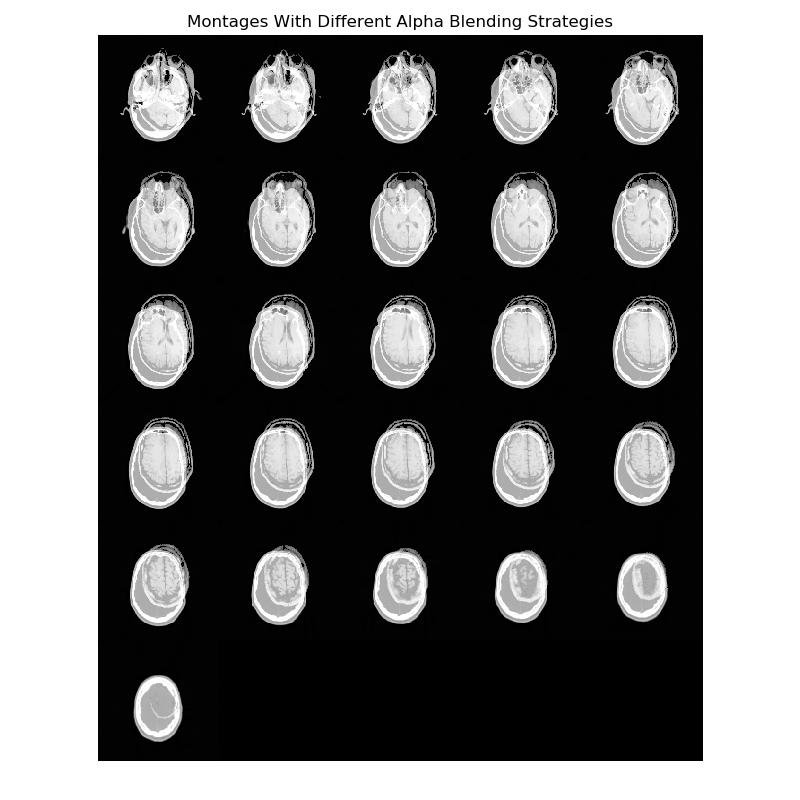

In [28]:
# Combine the two volumes
images_list = [(alpha_blend(img1_255, img2_255), 'alpha_blend_standard'), #在img1和img2所有前景位置alpha混合
               (alpha_blend(img1_255, img2_255, mask1=msk1), 'alpha_blend_mask1'),#在img1的前景位置alpha混合，其他位置直接复制前景:img2的前景位置将更显著
               (alpha_blend(img1_255, img2_255, mask2=msk2),'alpha_blend_mask2'),#在img2的前景位置alpha混合，其他位置直接复制前景:img1的前景位置将更显著
               (alpha_blend(img1_255, img2_255, mask1=msk1, mask2=msk2),'alpha_blend_mask1_mask2')]#只在img1和img2相交前景位置alpha混合

# Tile the volumes using the x-y plane (axial slices)
all_montages = []
for img,img_name in images_list:
    num_slices = img.GetDepth()
    tile_w = int(np.sqrt(num_slices))
    tile_h = int(np.ceil(num_slices/tile_w))
    tile_image = sitk.Tile([img[:,:,i] for i in range(num_slices)], (tile_w, tile_h))
    sitk.WriteImage(sitk.Cast(tile_image, sitk.sitkUInt8), os.path.join(OUTPUT_DIR,img_name+'.png'))
    all_montages.append(tile_image)

# Display all montages by combining them into a faux volume. Notice that scrolling through this
# volume creates the illusion of motion due to the change in intensities (the interested
# reader is referred to "Visual dissociations of movement, position, and stereo depth: Some phenomenal 
# phenomena", R. L. Gregory, P. F. Heard).

#有26张slice
gui.MultiImageDisplay(image_list = [sitk.JoinSeries(all_montages)],
                      title_list = ['Montages With Different Alpha Blending Strategies'],
                      figure_size=(8,8));

## 混合图像-Checkerboard

使用棋盘图案组合原始窗口图像和强度窗口图像。 这说明需要将两个图像映射到相同的强度范围。 这在背景区域尤其明显，其中两个图像都包含空气。

您可以指定每个维度的棋盘格数量，如下所示。 棋盘拼贴的实际数量取决于每个维度的像素数和指定的拼贴数。 您可能会获得比指定更多的切片，例如尝试在下面指定[4,4,7]。

sitk.CheckerBoard(Image image1, Image image2, VectorUInt32 checkerPattern)

以棋盘图案组合两个图像。此函数直接调用CheckerBoardImageFilter的execute方法以支持过程API

- image1:要混合的图像1
- image2:要混合的图像2
- checkerPattern： 分割棋盘的模式,元组或列表 e.g.[4,4,4]/(10,10,4)

In [31]:
help(sitk.CheckerBoard)

Help on function CheckerBoard in module SimpleITK.SimpleITK:

CheckerBoard(*args, **kwargs)
    CheckerBoard(Image image1, Image image2, VectorUInt32 checkerPattern) -> Image
    
    
    
    Combines two images in a checkerboard pattern.
    
    
    This function directly calls the execute method of CheckerBoardImageFilter in order to support a procedural API
    
    
    See:
     itk::simple::CheckerBoardImageFilter for the object oriented interface



<IPython.core.display.Javascript object>


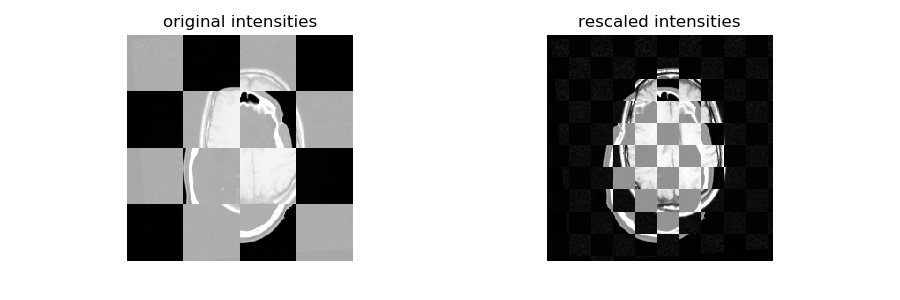

In [30]:
gui.MultiImageDisplay(image_list = [sitk.CheckerBoard(img1, img2, [4,4,4]), sitk.CheckerBoard(img1_255, img2_255, (10,10,4))],
                      title_list = ['original intensities', 'rescaled intensities'],
                      figure_size=(9,3));

## 将标量图组合成彩色图-Combine scalar images to create color image 

我们可以通过多种方式组合标量图像来创建彩色图像。 这些组合中的一些应该避免，因为它们不能被很大一部分人识别(即红绿通道编码)。 有关其他详情，请参阅

M. Geissbuehler，T。Lasser，“如何通过与红绿色感知缺陷兼容的配色方案显示数据”，Opt Express。，21（8）：9862-74,2013。

In [32]:
help(sitk.Compose)

Help on function Compose in module SimpleITK.SimpleITK:

Compose(*args)
    Compose(VectorOfImage images) -> Image
    Compose(Image image1) -> Image
    Compose(Image image1, Image image2) -> Image
    Compose(Image image1, Image image2, Image image3) -> Image
    Compose(Image image1, Image image2, Image image3, Image image4) -> Image
    Compose(Image image1, Image image2, Image image3, Image image4, Image image5) -> Image



(256, 256, 26)
1
Max, Min differences of msk1 are : 0.0, 0.0


<IPython.core.display.Javascript object>


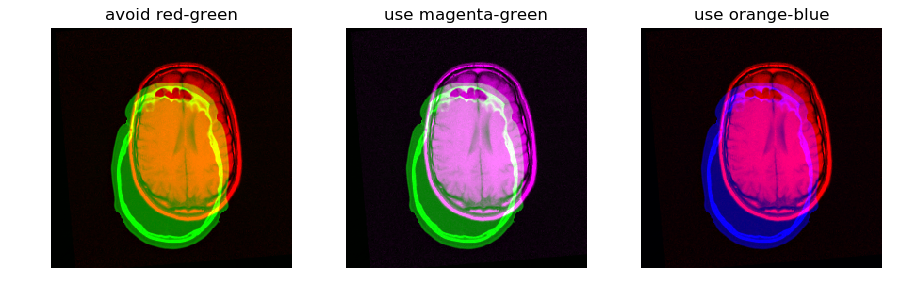

In [56]:
zeros = sitk.Image(img1_255.GetSize(), img1_255.GetPixelID())
#CopyInformation不会copy像素值
zeros.CopyInformation(img1_255)

print(img1_255.GetSize())
print(img1_255.GetNumberOfComponentsPerPixel())

statistics_image_filter=sitk.StatisticsImageFilter()
statistics_image_filter.Execute(zeros)
print('Max, Min differences of msk1 are : {0}, {1}'.format(statistics_image_filter.GetMaximum(), statistics_image_filter.GetMinimum()))

#三个通道，指定每个通道的像素分量值
gui.MultiImageDisplay(image_list = [sitk.Cast(sitk.Compose(img1_255,img2_255,zeros), sitk.sitkVectorUInt8),
                                    sitk.Cast(sitk.Compose(img1_255, img2_255, img1_255), sitk.sitkVectorUInt8),
                                   sitk.Cast(sitk.Compose(img1_255, 0.5*img1_255+0.5*img2_255, img2_255), sitk.sitkVectorUInt8)],
                      title_list= ['avoid red-green', 'use magenta-green', 'use orange-blue'],
                      figure_size=(9,3));

## 通过颜色映射将标量图像叠加到另一个上-Overlay scalar image onto another via color map

在某些情况下，我们有一个底层图像（空间结构），我们想要在它上面叠加一个基于标量的伪彩色图像。

这与提供共同配准的PET / CT数据相关，PET提供功能信息，CT提供基础空间结构。 **深度学习环境中的类似用例是显示激活图，该激活图示出了图像中的区域，网络正在该区域关注特定类。**

我们做出的两个主要决定是：

1. 使用支持各种颜色映射的[ScalarToRGBColormapImageFilter](https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ScalarToRGBColormapImageFilter.html)选择伪颜色方案。

2. Alpha混合方法（alpha值和掩码的使用，如上所述）。


In [46]:
help(sitk.SignedMaurerDistanceMap)

Help on function SignedMaurerDistanceMap in module SimpleITK.SimpleITK:

SignedMaurerDistanceMap(image1, insideIsPositive=False, squaredDistance=True, useImageSpacing=False, backgroundValue=0.0)
    SignedMaurerDistanceMap(Image image1, bool insideIsPositive=False, bool squaredDistance=True, bool useImageSpacing=False, double backgroundValue=0.0) -> Image
    
    
    
    This filter calculates the Euclidean distance transform of a binary
    image in linear time for arbitrary dimensions.
    
    
    This function directly calls the execute method of SignedMaurerDistanceMapImageFilter in order to support a procedural API
    
    
    See:
     itk::simple::SignedMaurerDistanceMapImageFilter for the object oriented interface



<IPython.core.display.Javascript object>


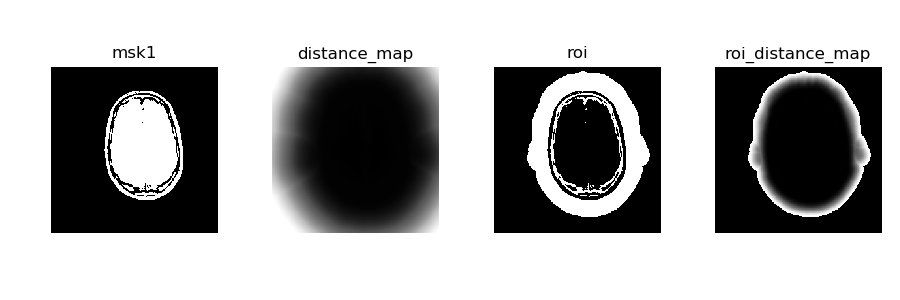

3


<IPython.core.display.Javascript object>


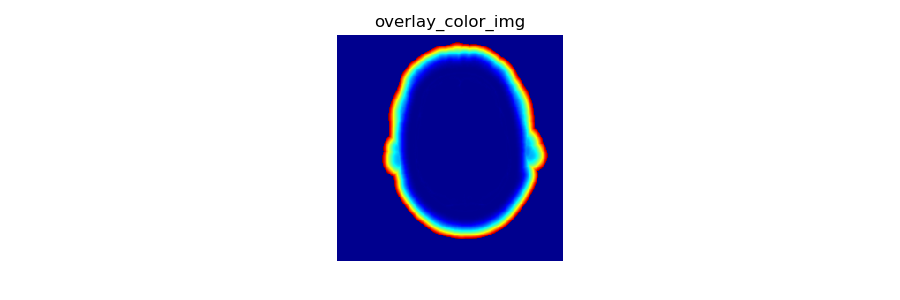

<IPython.core.display.Javascript object>


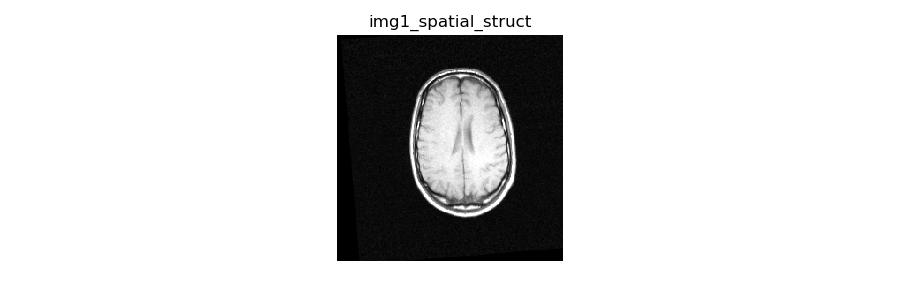

<IPython.core.display.Javascript object>


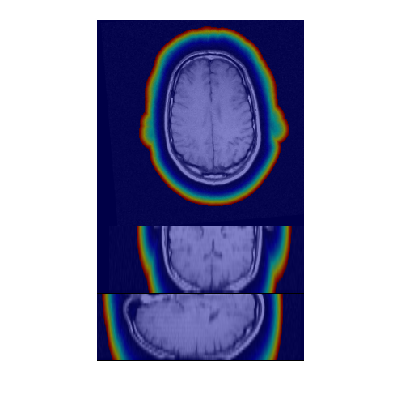

In [51]:
# Create a signed distance map which we will overlay onto the original image using 
# pseudo-coloring. We are only interested in locations that are at a distance of [0,512] from the object 

#创建一个带符号的距离图，我们将使用伪着色将其覆盖到原始图像上。 我们只对与物体相距[0,512]的位置感兴趣
distance_map = sitk.SignedMaurerDistanceMap(msk1)

# roi区域:distance_map=[0,512]
roi = sitk.Cast(distance_map>0.0, sitk.sitkFloat32)*sitk.Cast(distance_map<512.0, sitk.sitkFloat32)

#得到roi区域的distance_map
roi_distance_map = roi*distance_map

gui.MultiImageDisplay(image_list = [msk1,distance_map,roi,roi_distance_map],
                      title_list= ['msk1', 'distance_map','roi', 'roi_distance_map'],
                      figure_size=(9,3));


#sitk.ScalarToRGBColormap:将灰度roi_distance_map转化为彩色(RGB)叠加volume
overlay_color_img = sitk.ScalarToRGBColormap(roi_distance_map, 
                                             sitk.ScalarToRGBColormapImageFilter.Jet)
#通道数:3
print(overlay_color_img.GetNumberOfComponentsPerPixel())


gui.MultiImageDisplay(image_list = [overlay_color_img],
                      title_list= ['overlay_color_img'],
                      figure_size=(9,3));

#使用Alpha混合将彩色叠加volume与空间结构体积相结合，并将其转换为三元组向量8位无符号整数。 
#我们可以很容易地将一个mask加入到混合物中（双关语）。 通过添加mask2 = roi，我们可以将叠加限制在感兴趣的区域。


#将灰度图compose到三通道
img1_spatial_struct=sitk.Compose(img1_255, img1_255, img1_255)

gui.MultiImageDisplay(image_list = [img1_spatial_struct],
                      title_list= ['img1_spatial_struct'],
                      figure_size=(9,3));

combined_volume = sitk.Cast(alpha_blend(img1_spatial_struct, 
                                        overlay_color_img), 
                            sitk.sitkVectorUInt8)

#给定volume，我们可以创建如上所述的蒙太奇，或者我们可以采用代表性slice（轴向/矢状/冠状）。 
#由于手稿中使用的图像格式假定各向同性像素，我们需要在写入磁盘之前确保这一点。

#[中间宽度slice图像,中间高度slice图像，中间深度slice图像]
all_central_slices = [combined_volume[:,:,int(combined_volume.GetDepth()/2.0 + 0.5)],
                      combined_volume[:,int(combined_volume.GetHeight()/2.0 + 0.5),:],
                      combined_volume[int(combined_volume.GetWidth()/2.0 + 0.5),:,:]]

# 将每个slice图像根据最小spacing值resample到各向同性
for i, img in enumerate(all_central_slices):
    all_central_slices[i] = make_isotropic(img)
    sitk.WriteImage(all_central_slices[i], 
                    os.path.join(OUTPUT_DIR,'color_overlay{0}.png'.format(i)))
    
gui.multi_image_display2D([sitk.Tile(all_central_slices,(1,3))],  
                          figure_size=(4,4),horizontal=False);

# 组合图像和分割图-Combining an image and segmentation

要在上下文中显示分割结果，我们需要将它们叠加到原始图像上。 这样做有两种常见的选择：

- 将分割标签映射到彩色图像并将alpha混合映射到原始图像上。
- 将分割边界叠加到原始图像上。

我们在下面说明了两种方法

对于此示例，我们使用经点验证的基于像素的呼吸胸模型（POPI）模型。

Fetching POPI/meta/00-P.mhd
Fetching POPI/masks/00-air-body-lungs.mhd
origin_image_size:(482, 360, 141),origin_image_channels:1
origin_image_size:(482, 360, 141),origin_image_channels:1
origin_image_size:(482, 360, 141),origin_image_channels:3


<IPython.core.display.Javascript object>


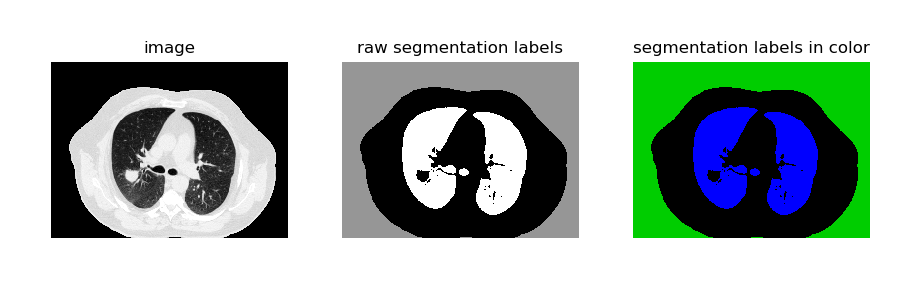

In [60]:
# Load utilities that are specific to the POPI data, the label values associated with the segmentation.
%run popi_utilities_setup.py

img = sitk.ReadImage(fdata('POPI/meta/00-P.mhd'))
segmentation = sitk.ReadImage(fdata('POPI/masks/00-air-body-lungs.mhd'))

#sitk.LabelToRGB将灰度分割图转化为RGB彩色图
RGB_segmentation=sitk.LabelToRGB(segmentation)

print("origin_image_size:{0},origin_image_channels:{1}".format(img.GetSize(),img.GetNumberOfComponentsPerPixel()))
print("origin_image_size:{0},origin_image_channels:{1}".format(segmentation.GetSize(),segmentation.GetNumberOfComponentsPerPixel()))
print("origin_image_size:{0},origin_image_channels:{1}".format(RGB_segmentation.GetSize(),RGB_segmentation.GetNumberOfComponentsPerPixel()))

gui.MultiImageDisplay(image_list = [img, segmentation, sitk.LabelToRGB(segmentation)],                   
                      title_list = ['image', 'raw segmentation labels', 'segmentation labels in color'],
                      figure_size=(9,3), shared_slider=True);

我们将使用此数据集中的中央冠状切片。

#### 使用上面的GUI确定我们图像的所需强度范围，将高动态范围图像映射到低动态范围，[0,255]，提取中央冠状切片，然后将其翻转以用于显示目的。

In [61]:
#取原图中间高度的slice，翻转后，映射到低动态强度范围
coronal_255 = sitk.Cast(sitk.IntensityWindowing(img[:,int(img.GetHeight()/2),:][:,::-1], 
                                                windowMinimum=-1000, windowMaximum=170, 
                                                outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)
coronal_255_isotropic = make_isotropic(coronal_255)

#size=[482,289] channels=1
print("coronal_255_isotropic_size:{0},coronal_255_isotropic_channels:{1}"
      .format(coronal_255_isotropic.GetSize(),coronal_255_isotropic.GetNumberOfComponentsPerPixel()))


coronal_255_isotropic_size:(482, 289),coronal_255_isotropic_channels:1


在许多情况下，标签图像中的值不适合直接显示。 例如，我们的标签图像中的值是0,1,2。 如果将光标悬停在上方的原始分割标签图像上（图的右下角），则可以看到这些值。

从理论上讲，我们可以将这些强度映射到[0,255]并保存图像。 在实践中，我们可能有超过256个标签，因此最好将标签映射到颜色并保存彩色图像。

In [62]:
# Use the default color map when mapping labels to colors and write the image.

#取分割图中间高度的slice，翻转
coronal_segmentation = segmentation[:,int(segmentation.GetHeight()/2),:][:,::-1]

#对label图变换时，使用最近领域插值法
#size=[482,289] channels=1
coronal_segmentation_isotropic = make_isotropic(coronal_segmentation, sitk.sitkNearestNeighbor)
print("coronal_segmentation_isotropic_size:{0},coronal_segmentation_isotropic_channels:{1}"
      .format(coronal_segmentation_isotropic.GetSize(),coronal_segmentation_isotropic.GetNumberOfComponentsPerPixel()))

#size=[482,289] channels=3
GRB_coronal_segmentation_isotropic=sitk.LabelToRGB(coronal_segmentation_isotropic)
print("GRB_coronal_segmentation_isotropic_size:{0},GRB_coronal_segmentation_isotropic_channels:{1}"
      .format(GRB_coronal_segmentation_isotropic.GetSize(),GRB_coronal_segmentation_isotropic.GetNumberOfComponentsPerPixel()))

sitk.WriteImage(GRB_coronal_segmentation_isotropic,os.path.join(OUTPUT_DIR, 'coronal_segmentation.png'))

coronal_segmentation_isotropic_size:(482, 289),coronal_segmentation_isotropic_channels:1
GRB_coronal_segmentation_isotropic_size:(482, 289),GRB_coronal_segmentation_isotropic_channels:3


## 将分割标签叠加到原始图像上-Overlay segmentation labels onto original image

SimpleITK允许您使用color map和Alpha混合将分割标签叠加到原始图像上。 您可以指定Alpha混合的值，color map（有一个默认的color map），以及不会用标签覆盖的背景标签值。

SimpleITK中的color map是串联在一起的RGB颜色空间中的一组值。 例如，[255,0,0,0,255,0]是带有红色和绿色的两个条目color map。 要创建人类可读的color map，请使用列表来表示颜色并将它们串在一起，如下所示。

### sitk.LabelOverlay

### sitk.JoinSeries

### 

coronal_combined1_size:(482, 289),coronal_combined1_channels:3
coronal_combined2_size:(482, 289),coronal_combined2_channels:3
coronal_join_size:(482, 289, 2),coronal_join_channels:3


<IPython.core.display.Javascript object>


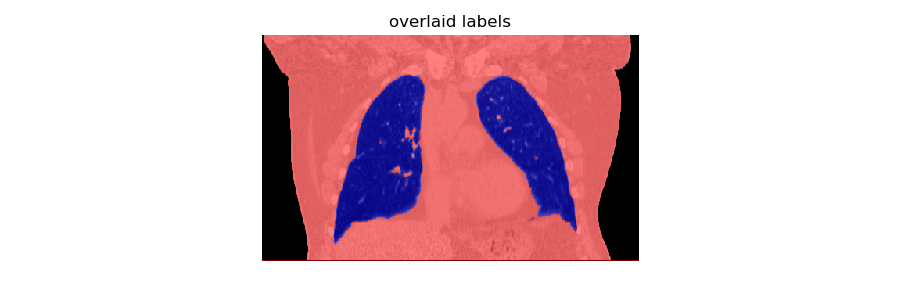

In [65]:
# 使用默认color map和0.5的alpha值覆盖分割
coronal_combined1 = sitk.LabelOverlay(image=coronal_255_isotropic, 
                                     labelImage=coronal_segmentation_isotropic,
                                     opacity=0.5, backgroundValue=air_label)
print("coronal_combined1_size:{0},coronal_combined1_channels:{1}"
      .format(coronal_combined1.GetSize(),coronal_combined1.GetNumberOfComponentsPerPixel()))

# 创建一个“有趣的”color map，并将backgroundValue指定为不存在的标签，以便背景标签也重叠。
pink= [255,105,180]
green = [0,255,0]
gold = [255,215,0]
coronal_combined2 = sitk.LabelOverlay(image=coronal_255_isotropic, 
                                     labelImage=coronal_segmentation_isotropic,
                                     opacity=0.5, backgroundValue = -1.0,
                                     colormap=pink+green+gold)
print("coronal_combined2_size:{0},coronal_combined2_channels:{1}"
      .format(coronal_combined2.GetSize(),coronal_combined2.GetNumberOfComponentsPerPixel()))


# 显示两个图像作为一个人造卷，sitk.JoinSeries([coronal_combined1, coronal_combined2])：在depth维度堆叠
coronal_join=sitk.JoinSeries([coronal_combined1, coronal_combined2])
print("coronal_join_size:{0},coronal_join_channels:{1}"
      .format(coronal_join.GetSize(),coronal_join.GetNumberOfComponentsPerPixel()))

gui.MultiImageDisplay(image_list = [coronal_join],                   
                      title_list = ['overlaid labels'],
                      figure_size=(9,3), shared_slider=True);

## 将分割边界叠加到原始图像上-Overlay segmentation boundaries onto original image

我们可以很容易地从原始分割中获得分割边界。 然后我们将轮廓保存为图像，或者我们可以直接将它们叠加到图像上。


有些要点需要注意：

1. 处理3D图像和分割时，我们的边界是曲面。 当这些表面与2D平面相交时，它们可以定义区域而不是轮廓，这是我们通常期望的（例如，由以下代码单元显示的结果中的slice 24）。

2. 当标签彼此相邻时，它们共享边界。 因此，绘制边界可能导致轮廓相互重写或轮廓交叉。

### sitk.LabelContour(segmentation, fullyConnected=True, backgroundValue=0)

作用:从分割图(单通道)上获得轮廓(单通道)

<IPython.core.display.Javascript object>


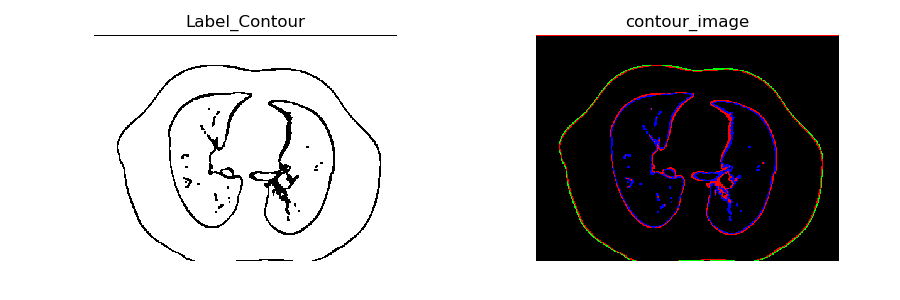

In [70]:
red = [255,0,0]
green = [0,255,0]
blue = [0,0,255]

# red goes to the first label, green to second, blue to third
# body_label=0, air_label=1, lung_label=2 

Label_Contour=sitk.LabelContour(segmentation, fullyConnected=True, backgroundValue=255)

#将label轮廓图转化为RGB图像
contour_image = sitk.LabelToRGB(Label_Contour, 
                                colormap=red+green+blue , backgroundValue=255)

gui.MultiImageDisplay(image_list = [Label_Contour,contour_image],
                      title_list = ['Label_Contour','contour_image'],
                      figure_size=(9,3));

在下面的代码单元格中，我们将轮廓叠加到原始图像上.
**我们使用的filter用于标签图图像(label-map image)而不是标签图像(label image).前者是用于表示分割图（运行长度编码）的更有效的数据结构。 因此，我们需要将标签图像转换为标签图图像.**

``sitk.Cast(coronal_segmentation_isotropic, sitk.sitkLabelUInt8)：将标签图像coronal_segmentation_isotropic转化为标签图图像``


我们还可以设置几个与可视化相关的参数，例如叠加不透明度(overlay opacity)，轮廓厚度(contour thickness)，叠加优先级(priority of overlay)（如果它们重叠则覆盖哪个标签）等。

### sitk.LabelMapContourOverlay(Image labelMapImage, Image featureImage, double opacity=0.5, VectorUInt32 dilationRadius, VectorUInt32 contourThickness,  ...colormap)
将标签图图像的轮廓叠加到原始图像上


In [72]:
help(sitk.LabelMapContourOverlay)

Help on function LabelMapContourOverlay in module SimpleITK.SimpleITK:

LabelMapContourOverlay(*args, **kwargs)
    LabelMapContourOverlay(Image labelMapImage, Image featureImage, double opacity=0.5, VectorUInt32 dilationRadius, VectorUInt32 contourThickness, unsigned int sliceDimension=0, itk::simple::LabelMapContourOverlayImageFilter::ContourTypeType contourType, itk::simple::LabelMapContourOverlayImageFilter::PriorityType priority, VectorUInt8 colormap) -> Image
    
    
    
    Apply a colormap to the contours (outlines) of each object in a label
    map and superimpose it on top of the feature image.
    
    
    This function directly calls the execute method of LabelMapContourOverlayImageFilter in order to support a procedural API
    
    
    See:
     itk::simple::LabelMapContourOverlayImageFilter for the object oriented interface



contour_overlaid_image_size:(482, 289),contour_overlaid_image_channels:3


<IPython.core.display.Javascript object>


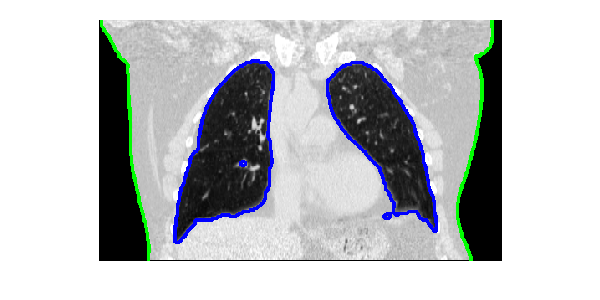

(<Figure size 600x300 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x249cb3aa0f0>])

In [82]:
contour_label_map=sitk.Cast(coronal_segmentation_isotropic, sitk.sitkLabelUInt8)
contour_overlaid_image = sitk.LabelMapContourOverlay(contour_label_map, 
                                                     coronal_255_isotropic, 
                                                     opacity = 1, 
                                                     contourThickness=[4,4],
                                                     dilationRadius= [3,3],
                                                     colormap=red+green+blue)

print("contour_overlaid_image_size:{0},contour_overlaid_image_channels:{1}"
      .format(contour_overlaid_image.GetSize(),contour_overlaid_image.GetNumberOfComponentsPerPixel()))

# gui.multi_image_display2D([contour_label_map],
#                           figure_size=(6,3))

gui.multi_image_display2D([contour_overlaid_image],
                          figure_size=(6,3))

# 比较两个分割图-Comparing two segmentations

在本节中，我们将展示如何创建二分图像，说明两个分割图所有的不同位置。 这是SimpleITK中的一个简单的线程。

下面的单元格通过放大图像上半部分的身体区域和下半部分的肺区域来修改我们原始的冠状区分割。

### sitk.BinaryDilateImageFilter()


coronal_segmentation_isotropic_size:(482, 289),coronal_segmentation_isotropic_channels:1
top_segmentation_size:(241, 289),top_segmentation_channels:1
bottom_segmentation_size:(241, 289),bottom_segmentation_channels:1
join_modified_size:(482, 289, 3),join_modified_channels:1


<IPython.core.display.Javascript object>


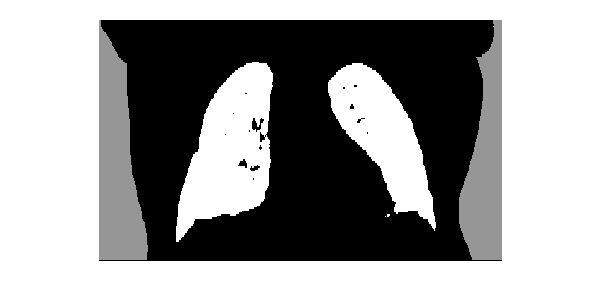

In [103]:
binary_dilate_filter = sitk.BinaryDilateImageFilter()
binary_dilate_filter.SetKernelRadius(2)

#中间高度
#mid_size = int(coronal_segmentation_isotropic.GetHeight()/2)
mid_size = int(coronal_segmentation_isotropic.GetWidth()/2)

# 在图像上方对体区域进行over-segment
#body_label=0
binary_dilate_filter.SetForegroundValue(body_label)
top_segmentation = binary_dilate_filter.Execute(coronal_segmentation_isotropic[0:mid_size,:])


print("coronal_segmentation_isotropic_size:{0},coronal_segmentation_isotropic_channels:{1}"
      .format(coronal_segmentation_isotropic.GetSize(),coronal_segmentation_isotropic.GetNumberOfComponentsPerPixel()))

print("top_segmentation_size:{0},top_segmentation_channels:{1}"
      .format(top_segmentation.GetSize(),top_segmentation.GetNumberOfComponentsPerPixel()))


# gui.MultiImageDisplay(image_list = [coronal_segmentation_isotropic],                   
#                       figure_size=(6,3));

top=sitk.Tile(top_segmentation,top_segmentation, (1,2))
#top.CopyInformation(coronal_segmentation_isotropic)
# gui.MultiImageDisplay(image_list = [top],                   
#                       figure_size=(6,3));


# 在图像下方对肺区域进行over-segment
#lung_label=2
binary_dilate_filter.SetForegroundValue(lung_label)
bottom_segmentation = binary_dilate_filter.Execute(coronal_segmentation_isotropic[mid_size:,:])


print("bottom_segmentation_size:{0},bottom_segmentation_channels:{1}"
      .format(bottom_segmentation.GetSize(),bottom_segmentation.GetNumberOfComponentsPerPixel()))


# gui.MultiImageDisplay(image_list = [bottom_segmentation],                   
#                       figure_size=(6,3));

modified_segmentation1 = sitk.Tile(top_segmentation,top_segmentation, (2,1))
modified_segmentation1.CopyInformation(coronal_segmentation_isotropic)

modified_segmentation2 = sitk.Tile(bottom_segmentation,bottom_segmentation, (2,1))
modified_segmentation2.CopyInformation(coronal_segmentation_isotropic)

# 人造卷，允许我们通过在它们之间来回切换来在视觉上比较两个分段。

join_modified=sitk.JoinSeries(coronal_segmentation_isotropic, modified_segmentation1,modified_segmentation2)
print("join_modified_size:{0},join_modified_channels:{1}"
      .format(join_modified.GetSize(),join_modified.GetNumberOfComponentsPerPixel()))

gui.MultiImageDisplay(image_list = [join_modified],                   
                      figure_size=(6,3));

为了查看两个分割图的不同之处，我们直接比较它们。 如果我们不想浪费墨水，我们可以反转结果，使黑色像素为前景，白色为背景。

In [84]:
diff_image = (coronal_segmentation_isotropic!=modified_segmentation)
sitk.WriteImage(diff_image*255, os.path.join(OUTPUT_DIR,'segmentation_differences.jpg'))
sitk.WriteImage((diff_image!=1)*255, os.path.join(OUTPUT_DIR,'segmentation_differences_inverted.jpg'))